为了能够更加方便测试数据集合，比较各个算法模型的优劣，构建一个竞技场。目前主要支持4个平台的测试：

- arsenal
- sklearn
- spark mllib
- tensorflow


In [9]:
import os
index = os.getcwd().rfind("/notebook")
if index > 0: os.chdir(os.getcwd()[:index])

In [14]:

# Package imports
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

import eipi10.ml.neural_network as nn
import eipi10.ml.linear_model as lm
from eipi10.ml.planar_utils import *
from eipi10.ml.utils import *
from eipi10.test.testCases_v2 import *
from eipi10.ml.predictor import *
import logging

%matplotlib inline

# 1. 数据

train_X_orig.shape=(2, 300)
train_Y_orig.shape=(1, 300)
test_X_orig.shape=(2, 100)
test_Y_orig.shape=(1, 100)


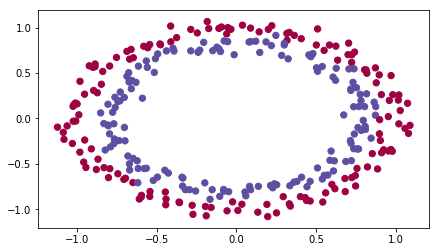

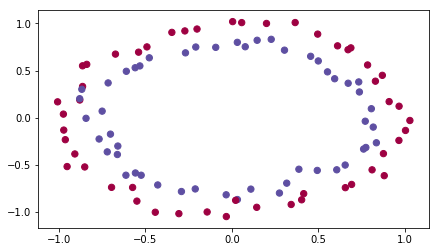

In [15]:
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

train_X_orig, train_Y_orig, test_X_orig, test_Y_orig = load_circle_dataset()
print("train_X_orig.shape={}".format(train_X_orig.shape))
print("train_Y_orig.shape={}".format(train_Y_orig.shape))
print("test_X_orig.shape={}".format(test_X_orig.shape))
print("test_Y_orig.shape={}".format(test_Y_orig.shape))

# Visualize train data
plt.scatter(train_X_orig.T[:, 0], train_X_orig.T[:, 1], c=train_Y_orig[0,:].T, s=40, cmap=plt.cm.Spectral)
plt.show()
plt.scatter(test_X_orig.T[:, 0], test_X_orig.T[:, 1], c=test_Y_orig[0,:].T, s=40, cmap=plt.cm.Spectral)

# 2. arsenal 

## 2.1 Logistic Regression


- 尝试不同的degree， 发现  
    - degree=1： 线性分类，无法分开
    - degree=2:  已经可以取到>98%的准确率
    - degree=5： 准确率反而下降。原因在什么地方呢？
 
    
- 尝试不同的learning_rate, 发现当learning_rate=0.2时，得到

    On the train set:  
    Accuracy: 0.986666666667  
    On the test set:  
    Accuracy: 0.96  
    
    

- 发现稍微有一点点过拟合，尝试修改了Regularizer的alpha系数
    - aplha = 0-20: 发现效果不大, 准确率几乎不变。

In [ ]:
reload(lm)

train_X, train_Y, test_X, test_Y =  (train_X_orig, train_Y_orig, test_X_orig, test_Y_orig)
degree=2
train_X = map_feature(train_X, degree)
test_X = map_feature(test_X, degree)

print("train_X.shape={}".format(train_X.shape))
print("train_Y.shape={}".format(train_Y.shape))
print("test_X.shape={}".format(test_X.shape))
print("test_Y.shape={}".format(test_Y.shape))

model = lm.LogisticRegression(num_features=train_X.shape[0], activator=Sigmoid,   
                              regularizer=L2Regularizer(2), iterator=NumberIterator(500), 
                              optimizer=GradientOptimizer(0.2), initializer=WeightInitializer(),
                              keep_cost_num_epoch=50)

model.fit(train_X, train_Y, print_cost=True, print_num_epoch=50)   


model.plot_costs()
predictor = ClassificationPredictor(arsenal_lr_model)
predictor.print_metrics(train_X, train_Y, test_X=test_X, test_Y=test_Y)
predictor.plot_decision_boundary(model, train_X_orig, train_Y, degree=degree)

INFO: Cost after epoch 0: 0.6931471806


train_X.shape=(5, 300)
train_Y.shape=(1, 300)
test_X.shape=(5, 100)
test_Y.shape=(1, 100)


## 2.2 神经网络



Step 1
* learning rate($\alpha$) 是首要的需要调节的参数 :  算法能够很快的收敛，设定learning rate=0.01  
    On the train set:  
    Accuracy: 0.996666666667  
    On the test set:  
    Accuracy: 0.95  

Step 2
* $\beta $ for momentum. 0.9 is default  : 直接使用Adam了
* mini-batch size: 
    - mini-batch size=50, epoch_times=500： 发现cost还是有一些震荡，设learning rate=0.001，发现test arrcuracy有很大的提升。 
    On the train set:   
    Accuracy: 0.973333333333   
    On the test set:   
    Accuracy: 0.98   

    但是当epoch_times从500增加到1000，test accuracy 又降低了
    On the train set:  
    Accuracy: 0.98  
    On the test set:  
    Accuracy: 0.96  
    
    
    - mini-batch size=100, epoch_times=500: 这次结果似乎最好
    
    On the train set:  
    Accuracy: 0.98  
    On the test set:  
    Accuracy: 0.97  

* hidden units：  
    - num_neurons=[train_X.shape[0], 20, 1], 调整神经元的个数，发现变化不大，甚至更糟

Step 3
* layers  
- activators=[Relu, Sigmoid], 调整网络层数，发现变化不大，甚至更糟。这也说明对于不够复杂的情况，层数适度就好。
* learning rate decay
    - learning rate = 0.001， 结果已经不错，无需再调整    
* $\beta 1,  \beta 2, \epsilon$ for Adam


In [433]:

learning_rate = 0.001

#batch
epoch_times = 1000
mini_batch = 100
print_num_epoch = 50
keep_cost_num_epoch = 50

#initialize
static_weight_scale=10

#regularize
alpha = 0
keep_prob = 1

#optimize
beta=0.9
beta1=0.9
beta2=0.99
epsilon=1e-8

train_X, train_Y, test_X, test_Y =  (train_X_orig, train_Y_orig, test_X_orig, test_Y_orig)
num_neurons=[train_X.shape[0], 20,1]
activators=[Relu, Sigmoid]

INFO: Cost after epoch 0: 0.8677466697
INFO: Cost after epoch 50: 0.6569745449
INFO: Cost after epoch 100: 0.6613195336
INFO: Cost after epoch 150: 0.6410438853
INFO: Cost after epoch 200: 0.6165924207
INFO: Cost after epoch 250: 0.5875073299
INFO: Cost after epoch 300: 0.5545494873
INFO: Cost after epoch 350: 0.5244546517
INFO: Cost after epoch 400: 0.4924180095
INFO: Cost after epoch 450: 0.4715034568
INFO: Cost after epoch 500: 0.4480025324
INFO: Cost after epoch 550: 0.3982145785
INFO: Cost after epoch 600: 0.3842879520
INFO: Cost after epoch 650: 0.3448908332
INFO: Cost after epoch 700: 0.3474715141
INFO: Cost after epoch 750: 0.3030804569
INFO: Cost after epoch 800: 0.2702069053
INFO: Cost after epoch 850: 0.2789192051
INFO: Cost after epoch 900: 0.2642604121
INFO: Cost after epoch 950: 0.2373152709
INFO: Final Cost after epoch 1000: 0.2254149094


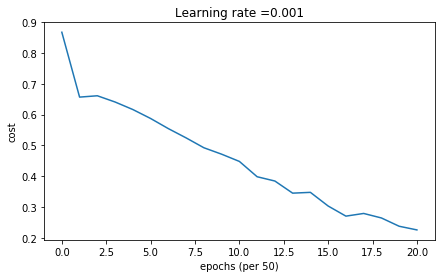

On the train set:
Accuracy: 0.98
On the test set:
Accuracy: 0.97


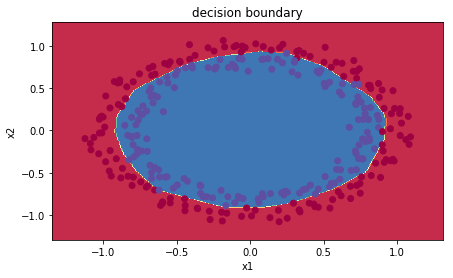

In [434]:
reload(nn)
model = nn.NeuralNetwork.build(
    num_neurons=num_neurons,
    activators=activators,      
    iterator=NumberIterator(epoch_times),
    initializer=HeWeightInitializer(),
    optimizer=nn.AdamOptimizer(learning_rate=learning_rate, beta1=beta1, beta2=beta2, epsilon=epsilon),
    keep_cost_num_epoch=keep_cost_num_epoch,
    mini_batch=mini_batch,
    regularizer=nn.L2Regularizer(alpha) ,
    keep_prob=keep_prob
)

model.fit(train_X, train_Y,  print_cost=True, print_num_epoch=print_num_epoch)
model.plot_costs()
model.print_accuracy_train_test(train_X, train_Y, test_X, test_Y)
model.plot_decision_boundary(train_X, train_Y)

# 3. sklearn

##  3.1 Logistic Regression 

参见http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [435]:
from sklearn import linear_model
from sklearn import neighbors

train_X, train_Y, test_X, test_Y =  (train_X_orig, train_Y_orig, test_X_orig, test_Y_orig)
degree=2
train_X = map_feature(train_X, degree)
test_X = map_feature(test_X, degree)

model = linear_model.LogisticRegression(C=0.001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=50000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

logistic = model.fit(train_X.T, np.ravel(train_Y))
print(model.score(train_X.T, np.ravel(train_Y)))
print(model.score(test_X.T, np.ravel(test_Y)))


0.5
0.5


knn = neighbors.KNeighborsClassifier()
knn = knn.fit(train_set_x.T, np.ravel(train_set_y))
print(knn.score(train_set_x.T, np.ravel(train_set_y)))
print(knn.score(test_set_x.T, np.ravel(test_set_y)))